## A numerical experiment: optimizing a sequence of linear maps

Suppose that we are given an integer $k \geq 1$, a $2x2$ matrix $\Phi \in \mathbb{R}^{2\times 2}$ and a polygon in vertex representation, $V_0$. We are interested in the sequence:

$$
V_k := \{V_0, \Phi V_0, \Phi^2 V_0, \ldots, \Phi^k V_0\}.
$$

In the following paragraphs we consider different versions of this operation in Julia.

The input data we consider, to fix ideas, is defined next.

In [1]:
using LazySets, Plots

In [40]:
Φ = [0.9 0.005; 0.0 1.0]

2×2 Array{Float64,2}:
 0.9  0.005
 0.0  1.0  

In [3]:
eigvals(Φ)

2-element Array{Float64,1}:
 0.9
 1.0

The matrix has spectral radius one, hence the matrix powers $\Phi^k$, $k\geq 1$ do not diverge.

The initial set considered, $V_0$, is a polygon with "diamond" shape (`Ball1` stands for the unit ball in the 1-norm in `LazySets`):

In [95]:
V0 = convert(VPolygon, Ball1(ones(2), 0.2))

VPolygon{Float64,Array{Float64,1}}(Array{Float64,1}[[0.8, 1.0], [1.0, 0.8], [1.2, 1.0], [1.0, 1.2]])

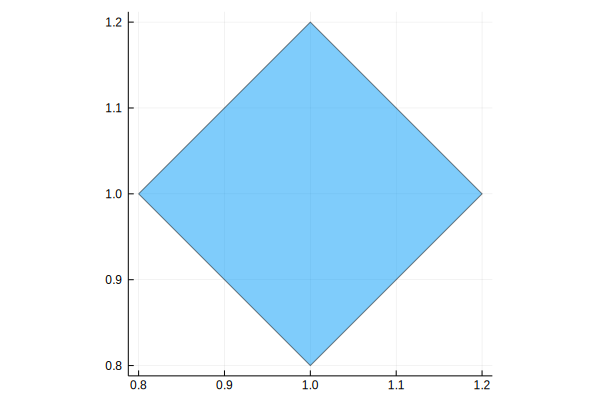

In [5]:
plot(V0)

Let us plot some successors of the sequence $V_k$: 

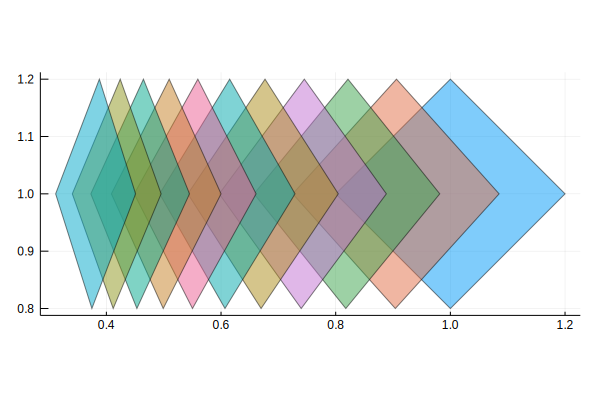

In [6]:
plot!([Φ^k * V0 for k in 1:10])

For the benchmarks we will consider $N = 100$.

In [7]:
N = 100

100

### Solution by list comprehension

The first, "naive" but simplest approach is to define the sequence by list comprehension. This is perhaps the simplest way to write this function, but we will see that there are more efficient implementations.

In [8]:
function sequence_v1(Φ, V0, N)
    return [linear_map(Φ^k, V0) for k in 1:N]
end

sequence_v1 (generic function with 1 method)

In [9]:
@btime res = sequence_v1($Φ, $V0, $N);

  129.974 μs (2203 allocations: 182.19 KiB)


One side note regarding the `linear_map` function of above. That function, in `LazySet`, will just apply the linear map `\Phi` to each vertex of the polygon and is implemented with a call to `broadcast`.

In [24]:
@which linear_map(Φ, V0)

linear_map(M::AbstractArray{N,2}, P::VPolygon{N,VN} where VN<:AbstractArray{N,1}) where N<:Real in LazySets at /Users/forets/.julia/dev/LazySets/src/VPolygon.jl:114

However, `sequence_v1_bare` is slower (why?).

In [10]:
function sequence_v1_bare(Φ, V0, N)
    return [broadcast(v -> Φ^k * v, V0) for k in 1:N]
end

sequence_v1_bare (generic function with 1 method)

In [12]:
@btime sequence_v1_bare($Φ, $V0.vertices, $N);

  204.759 μs (3403 allocations: 358.75 KiB)


In [21]:
sequence_v1(Φ, V0, N)[27].vertices

4-element Array{Array{Float64,1},1}:
 [0.0936123, 1.0]
 [0.0958237, 0.8]
 [0.116872, 1.0] 
 [0.114661, 1.2] 

In [22]:
sequence_v1_bare(Φ, V0.vertices, N)[27]

4-element Array{Array{Float64,1},1}:
 [0.0936123, 1.0]
 [0.0958237, 0.8]
 [0.116872, 1.0] 
 [0.114661, 1.2] 

### Preallocating the result and reducing the matrix multiplications

The first improvement consists of noticing that in the list comprehension of above, we compute more matrix powers than needed. For example, if $N = 3$, then the terms $\Phi^2 V_0$ and $\Phi^3 V_0$ require 3 products between $\Phi$ and itself, while if we store the value of $\Phi^k$ and compute $\Phi^3 = \Phi * (\Phi^2)$ we need only two products. In general, from $\Phi^2$ to $\Phi^N$ the naive approach needs $1+\ldots + (N-1) = N(N-1)/2 = (N^2-N)/2$ matrix-matrix products, note that it is quadratic in $N$. On the other hand, if we store the matrix powers of order $k$, only $N-1$ products are needed, and this is linear in $N$.

In [25]:
function sequence_v2(Φ::AbstractMatrix{NT}, V0::LT, N::Int) where {NT, LT<:LazySet{NT}}
    res = Vector{LT}(undef, N)
    res[1] = V0
    Φ_power_k = copy(Φ)
    @inbounds for i in 2:N
       res[i] = linear_map(Φ_power_k, V0)
       Φ_power_k = Φ_power_k * Φ
    end
    return res
end

sequence_v2 (generic function with 1 method)

In [26]:
@btime res = sequence_v2($Φ, $V0, $N);

  91.605 μs (1586 allocations: 115.45 KiB)


We have passed from `130us` to `91us`, that makes a 30% reduction in runtime. The total number of allocations has also dropped, from `182kb` to `115kb`.

The function `sequence_v2` can receive any LazySet for which the concrete linear map, `linear_map`, is defined. For instance, we can use it with any higher-dimensional polytope. Consider a similar diamond-shaped set but in dimension 10.

In [116]:
V0_d10 = convert(VPolytope, Ball1(ones(10), 0.2))

VPolytope{Float64}(Array{Float64,1}[[1.2, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.2, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.2, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.2, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.2, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.2, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.2, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.2, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.2, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.

In [117]:
Φ_d10 = rand(10, 10) .- 0.5

@btime sequence_v1_bare($Φ_d10, $V0_d10.vertices, $N);

  7.744 ms (16203 allocations: 12.29 MiB)


In [47]:
@btime sequence_v2($Φ_d10, $V0_d10, $N);

  344.055 μs (2378 allocations: 424.05 KiB)


In [48]:
344e-6 * 100 / 7.780e-3

4.42159383033419

In [50]:
7.780e-3 / 344e-6

22.61627906976744

The gains are considerably larger in higher dimension; we have passed from a factor 1.4x to a factor 22x.

### Caching the intermediate matrix powers

Now that we reduced the matrix-matrix multiplications, we realize that our algorithm is not very memory-friendly, in the sense that `Φ_power_k = Φ_power_k * Φ` in the "tight-loop" does not re-use the memory allocated by `Φ_power_k`. By adding a new matrix to cache the intermediate matrix-matrix multiplications we can reduce the number of allocations in the loop and hence the garbarge collector (GC) is called less often, with an impact in performance. 

In [51]:
function sequence_v3(Φ::AbstractMatrix{NT}, V0::LT, N::Int) where {NT, LT<:LazySet{NT}}
    res = Vector{LT}(undef, N)
    res[1] = V0
    Φ_power_k = copy(Φ)
    Φ_power_k_cache = similar(Φ)
    @inbounds for i in 2:N
        res[i] = linear_map(Φ_power_k, V0)
        mul!(Φ_power_k_cache, Φ_power_k, Φ)
        copy!(Φ_power_k, Φ_power_k_cache)
    end
    return res
end

sequence_v3 (generic function with 1 method)

In [53]:
@btime res = sequence_v3($Φ, $V0, $N);

  87.671 μs (1488 allocations: 104.73 KiB)


We see that both runtime and allocations have dropped, although only by a marginal value, from `91us` to `87us` and from `115kb` to `104kb`.

In [65]:
100(1 - 87 / 91)

4.395604395604391

Let's check if the difference is more notorious for a larger time horizon:

In [66]:
@btime res = sequence_v2($Φ, $V0, 500);
@btime res = sequence_v3($Φ, $V0, 500);

  456.008 μs (7986 allocations: 581.14 KiB)
  442.909 μs (7488 allocations: 526.67 KiB)


In [70]:
100(1 - 442 / 456), 100(1 - 526 / 581)

(3.0701754385964897, 9.46643717728055)

In [67]:
@btime sequence_v2($Φ_d10, $V0_d10, $N);
@btime sequence_v3($Φ_d10, $V0_d10, $N);

  344.335 μs (2378 allocations: 424.05 KiB)
  342.356 μs (2280 allocations: 338.30 KiB)


In [71]:
100(1 - 342 / 344), 100(1 - 338 / 424)

(0.5813953488372103, 20.28301886792453)

Here the reduction in the total number of allocations is `20%` for the five-dimensional case. Let's consider a 100-dimensional polytope:

In [73]:
V0_d100 = convert(VPolytope, Ball1(ones(100), 0.2))
Φ_d100 = rand(100, 100) .- 0.5

@btime sequence_v2($Φ_d100, $V0_d100, $N);
@btime sequence_v3($Φ_d100, $V0_d100, $N);

  337.962 ms (20298 allocations: 24.73 MiB)
  334.016 ms (20102 allocations: 17.25 MiB)


In [74]:
100(1 - 334 / 337), 100(1 - 17.2 / 24.7)

(0.8902077151335286, 30.364372469635626)

The gain reduction in the number of allocations is now of `30%`. 

### Using statically sized arrays

The following approach consists of using statically sized arrays (the size of the array can be determined from its type) to store the vertices of the polygon and the matrix-matrix and matrix-vector multiplications.

In [76]:
using StaticArrays

Let's consider our fastest version and try if it "just works" if the vertices are statically sized vectors:

First we need to convert the data to static arrays:

In [96]:
Φ

2×2 Array{Float64,2}:
 0.9  0.005
 0.0  1.0  

In [97]:
Φs = SMatrix{2, 2}(Φ)

2×2 SArray{Tuple{2,2},Float64,2,4}:
 0.9  0.005
 0.0  1.0  

In [98]:
V0.vertices[1]

2-element Array{Float64,1}:
 0.8
 1.0

In [99]:
convert(SVector{2}, V0.vertices[1])

2-element SArray{Tuple{2},Float64,1,2}:
 0.8
 1.0

*Note.* The following requires [LazySets#927](https://github.com/JuliaReach/LazySets.jl/issues/927), which at the time of writing is not available yet.

In [100]:
V0s = VPolygon([convert(SVector{2}, vi) for vi in V0.vertices])

VPolygon{Float64,SArray{Tuple{2},Float64,1,2}}(SArray{Tuple{2},Float64,1,2}[[0.8, 1.0], [1.0, 0.8], [1.2, 1.0], [1.0, 1.2]])

The version `v3` produces an error in the call to `copy!` function:

In [104]:
sequence_v3(Φs, V0s, N)

ErrorException: setindex!(::SArray{Tuple{2,2},Float64,2,4}, value, ::Int) is not defined.

The function `v2` works, though:

In [107]:
@btime sequence_v2($Φs, $V0s, $N);

  72.567 μs (1783 allocations: 137.00 KiB)


The runtime has dropped from `91us` to `72us`, that's another `20%`.

In [109]:
100(1-72/92)

21.739130434782606

Another option is to use mutable statically sized arrays.

In [127]:
Φm = MMatrix{2, 2}(Φ)
V0m = VPolygon([convert(MVector{2}, vi) for vi in V0.vertices])

VPolygon{Float64,MArray{Tuple{2},Float64,1,2}}(MArray{Tuple{2},Float64,1,2}[[0.8, 1.0], [1.0, 0.8], [1.2, 1.0], [1.0, 1.2]])

In [133]:
V0m

VPolygon{Float64,MArray{Tuple{2},Float64,1,2}}(MArray{Tuple{2},Float64,1,2}[[0.8, 1.0], [1.0, 0.8], [1.2, 1.0], [1.0, 1.2]])

Note taht we can pass an `MMatrix` for $\Phi$, and it can be used in combination with `v3`:

In [142]:
@btime sequence_v2($Φm, $V0s, $N);

  73.623 μs (1685 allocations: 132.41 KiB)


In [143]:
@btime sequence_v3($Φm, $V0s, $N);

  65.657 μs (1587 allocations: 127.81 KiB)


This is the fastest result which gets close to a factor 2 improvement over the initial version. 

### Using the formula of $\Phi^k$

For this particular problem, it is easy to obtain the formula for matrix powers. Actually if

$$
M = \begin{pmatrix} a & b \\ 0 & 1 \end{pmatrix},
$$
then for any $k\geq 1$ it holds that:
$$
M^k = \begin{pmatrix} a^k & \dfrac{b ~ (a^k - 1)}{a - 1} \\ 0 & 1 \end{pmatrix}.
$$

In [159]:
function sequence_v4(Φ::AbstractMatrix{NT}, V0::LT, N::Int) where {NT, LT<:LazySet{NT}}
    @assert size(Φ) == (2, 2)
    @assert Φ[2, 1] == zero(NT)
    @assert Φ[2, 2] == one(NT)
    a, b = Φ[1, 1], Φ[1, 2]
    @assert a != one(NT)
    
    Φ_power_k(k) = [a^k    b*(a^k - 1)/(a-1) ;
                    0                     1  ]
    
    res = Vector{LT}(undef, N)
    res[1] = V0
    @inbounds for k in 2:N
       res[k] = linear_map(Φ_power_k(k), V0)
    end
    return res
end

sequence_v4 (generic function with 1 method)

In [160]:
@btime sequence_v4($Φ, $V0, $N);

  313.215 μs (3372 allocations: 164.94 KiB)


This version is actually *slower* than the previous ones.